## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime
import ast

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import random
import isuelogit as isl
import glob
import time

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
# Path management
main_dir = str(Path(os.path.abspath("")).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

# Folder that contains information of reference O-D matrix/pairs and paths.
isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/mate


In [3]:
%load_ext autoreload
%autoreload 2

from pesuelogit.networks import read_OD, load_k_shortest_paths
from pesuelogit.etl import add_period_id

# Functions from internal modules
from mate.models import compute_generated_trips, compute_generation_factors, \
    regularization_kfold, create_mate_model_fresno
from mate.etl import build_network, get_tensors_by_year, data_curation
from mate.visualizations import plot_flow_vs_traveltime, plot_congestion_maps, plot_hyperparameter_grid_results
from mate.metrics import mse, mape, r2_score,  z2score, mdape
from mate.utils import read_paths

In [4]:
# Seed for reproducibility
_SEED = 2024
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [5]:
# To report global runtime
t0_global = time.time()

In [6]:
# Set timestamp to add in the filenames that are written in disk
ts = datetime.now().strftime('%y%m%d%H%M%S')
print('Timestamp:',ts)

Timestamp: 240129110519


### Hyperparameters and configurations

In [7]:
# Data
_DAYSOFWEEK = [1,2,3] # Monday:0, Sunday:6
_HOURS = np.arange(6,21) #_HOURS = [6,7,8, 15,16,17]

# Optimization
_EPOCHS = {'learning':20}
_LR = {'learning': 5e-2, 'generation':10}
_BATCH_SIZE = 1

# Number of splits for k-fold cross validation
_N_SPLITS_HP = 5

# The values in grid will replace the equilibrium hyperparameter in _LOSS_WEIGHTS
_GRID_EQUILIBRIUM_HP = [0, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

# These hyperparameters can be left in their current values
_LOSS_WEIGHTS ={'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}
_RELATIVE_GAP = float('inf')
_LOSS_METRIC  = z2score
_EVALUATION_METRIC = mdape
_DTYPE = tf.float32

_OPTIMIZERS = {key: tf.keras.optimizers.legacy.Adam(learning_rate=lr) for key, lr in _LR.items()}

# Exogenous attributes in utility function
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

## Read nodes and link-specific data

In [8]:
nodes_df = pd.read_csv('./input/network-data/fresno/nodes/fresno-nodes-gis-data.csv')

links_df = pd.read_csv('./input/network-data/fresno/links/fresno-link-specific-data.csv',
                       converters={"link_key": ast.literal_eval, "pems_id": ast.literal_eval})

## Build Fresno network

In [9]:
network = build_network(links_df=links_df, nodes_df=nodes_df, crs='epsg:4326', key= 'fresno')

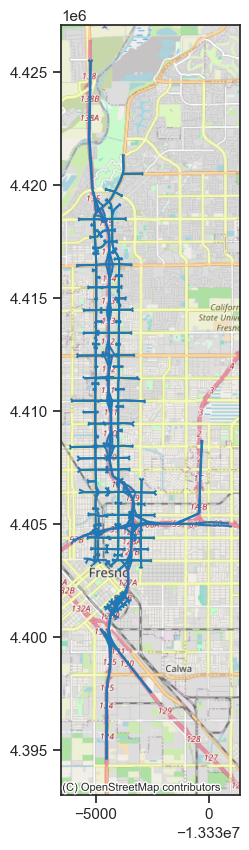

In [10]:
# Display network
fig, ax = plt.subplots(figsize=(10, 10))
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
links_gdf.to_crs(epsg=3857).plot(ax = ax)
ctx.add_basemap(ax = ax, source=ctx.providers.OpenStreetMap.Mapnik)

## Read and load OD matrix

In [11]:
read_OD(network=network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read and load paths

In [12]:
read_paths(network=network, update_incidence_matrices=True, filename = 'paths-fresno-k3.csv')

20840 paths were read and incidence matrices were built


## Read and process spatio-temporal link-level data

In [13]:
folderpath = './input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year

df['link_key'] = pd.Categorical(df['link_key'].apply(ast.literal_eval), list(network.links_dict.keys()))
df['period'] = pd.to_datetime(df['period'], format = '%Y-%m-%d-%H').dt.strftime('%Y-%m-%d-%H')

# Select data from Tuesdays to Thursdays
df = df[df['date'].dt.dayofweek.isin(_DAYSOFWEEK)]

# Select data from first Tuesdays of 2019 and 2020
# df = df[df['date'].isin(["2019-10-01", "2020-10-06"])]

In [14]:
# Add period id for timevarying estimation
period_feature = 'hour'

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [15]:
# Curation of travel time and link flow related features
df = data_curation(df)

In [16]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

In [17]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in network.links:
    network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==link.key].iloc[0])

# Set capacity in links considering number of lanes
capacity_links = df.groupby('link_key')['capacity'].mean()
for link in network.links:
    network.links_dict[link.key].performance_function.k = float(capacity_links[capacity_links.index==link.key].iloc[0])

## Process node-level data

In [18]:
nodes_df = nodes_df.rename(columns ={'pop_tract':'population','stops_tract': 'bus_stops','median_inc':'income'})

features_generation = ['population','income', 'bus_stops']

nodes_df = nodes_df[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(nodes_df[features_generation])
nodes_df[features_generation] = imp_mean.transform(nodes_df[features_generation])

scaler = preprocessing.StandardScaler().fit(nodes_df[features_generation].values)
nodes_df[features_generation] = scaler.transform(nodes_df[features_generation].values)

## Training and validation sets

In [19]:
XT, YT = get_tensors_by_year(df[df.hour.isin(_HOURS)], features_Z = _FEATURES_Z, links_keys=list(network.links_dict.keys()))

# Split in training and test sets
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

### Reference O-D matrix and trip generation vectors

In [20]:
q_historic = np.repeat(network.q.flatten()[np.newaxis, :], len(_HOURS), axis=0)

#Adjust historic O-D and historic trip generation
generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

reference_q = q_historic*np.tile(generation_factors.values,(q_historic.shape[1],1)).T

reference_g = compute_generated_trips(q = reference_q, ods= network.ods, n_nodes = len(network.nodes))

## Models

In [21]:
train_results_dfs = {}
val_results_dfs = {}
models = {}

## Search of optimal hyperparameter weighting the equilibrium component

In [22]:
target_metric = 'mse'
target_component = 'flow'

loss_weights = []

if isinstance(_GRID_EQUILIBRIUM_HP, (int, float)):
    _GRID_EQUILIBRIUM_HP = [_GRID_EQUILIBRIUM_HP]

for i in _GRID_EQUILIBRIUM_HP:
    loss_weights.append(_LOSS_WEIGHTS.copy())
    loss_weights[-1]['equilibrium'] = i

In [ ]:
model = create_mate_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                                       reference_g = reference_g, dtype = _DTYPE)

hp_metrics_df, optimal_weights, optimal_metrics_kfold_df, optimal_parameters_kfold_df \
    = regularization_kfold(
    loss_weights=loss_weights,
    target_metric = target_metric,
    target_component = target_component,
    n_splits=_N_SPLITS_HP,
    random_state=_SEED,
    model=model,
    X=XT_train, Y=YT_train,
    optimizers=_OPTIMIZERS,
    node_data=nodes_df,
    loss_metric=_LOSS_METRIC,
    evaluation_metric=_EVALUATION_METRIC,
    epochs_print_interval = _EPOCHS.copy(),
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs=_EPOCHS,
)

filepath = f"output/tables/{ts}_hyperparameter_tuning_{'fresno'}.csv"
hp_metrics_df.to_csv(filepath, index=False)

In [23]:
hp_plot_df = pd.read_csv(filepath)

# #Use offline results
# filenames = ['231222181721','231222181742','231222181812', '231222181829', '231222181850', '231222181907']
# hp_plot_df = pd.concat([pd.read_csv(f"output/tables/{j}_hyperparameter_tuning_fresno.csv").drop(['replicate'], axis = 1).assign(replicate = i) for i, j in enumerate(filenames)])

In [24]:
hp_plot_df = hp_plot_df.sort_values(by = ['component', 'lambda_equilibrium', 'dataset']).reset_index().drop(['index'], axis = 1)
hp_plot_df

,component,dataset,value,lambda_od,lambda_traveltime,lambda_flow,lambda_equilibrium,relative_gap,replicate
0,equilibrium,training,1.702259e+06,0,1,1,0.000,1.058879,0
1,equilibrium,validation,1.702259e+06,0,1,1,0.000,1.058879,0
2,equilibrium,training,1.489758e+06,0,1,1,0.001,0.941547,1
3,equilibrium,validation,1.489758e+06,0,1,1,0.001,0.941547,1
4,equilibrium,training,6.144092e+05,0,1,1,0.010,0.491775,2
5,equilibrium,validation,6.144092e+05,0,1,1,0.010,0.491775,2
6,equilibrium,training,4.743377e+04,0,1,1,0.100,0.106445,3
7,equilibrium,validation,4.743377e+04,0,1,1,0.100,0.106445,3
8,equilibrium,training,1.014430e+04,0,1,1,1.000,0.042602,4
9,equilibrium,validation,1.014430e+04,0,1,1,1.000,0.042602,4


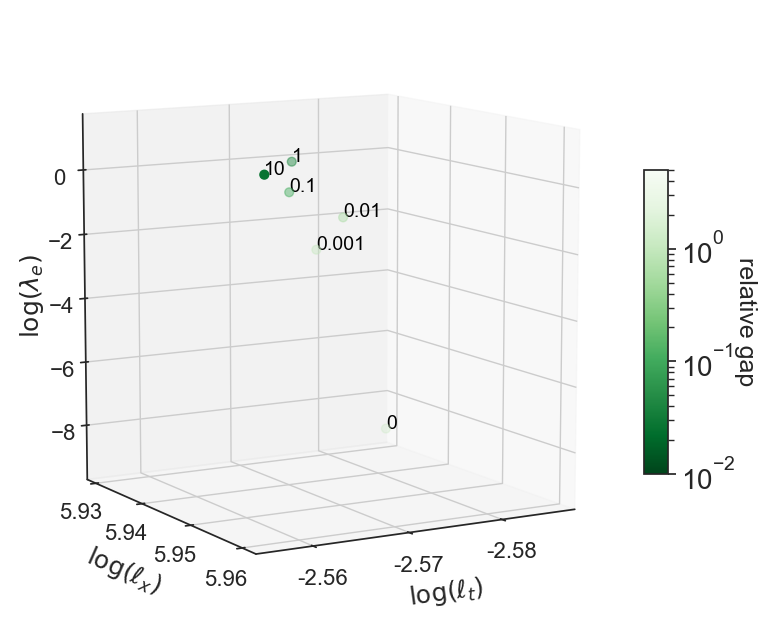

In [25]:
# Training set
fig, ax = plot_hyperparameter_grid_results(hp_plot_df[(hp_plot_df.dataset == 'training')])
ax.view_init(elev=10., azim=60, roll=0)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.savefig(f"output/figures/results/fresno-hyperpameter-grid-training-mate.png", dpi = 300, bbox_inches='tight')

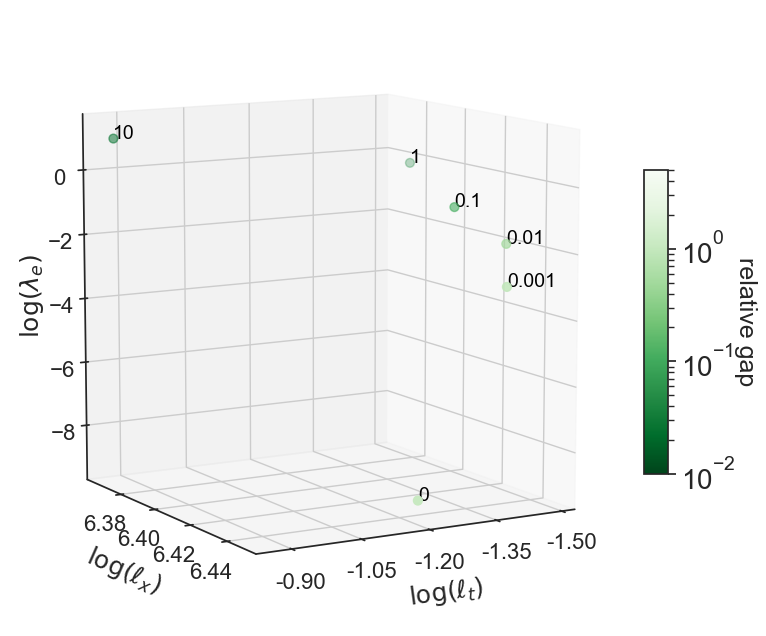

In [26]:
# Validation set
fig, ax = plot_hyperparameter_grid_results(hp_plot_df[(hp_plot_df.dataset == 'validation')])
ax.view_init(elev=10., azim=60, roll=0)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
plt.savefig(f"output/figures/results/fresno-hyperpameter-grid-validation-mate.png", dpi = 300, bbox_inches='tight')

### Estimation of MATE with optimal hyperparameters

In [27]:
# Select optimal weight
optimal_weights = _LOSS_WEIGHTS.copy()
optimal_weights['equilibrium'] = hp_plot_df.loc[hp_plot_df[(hp_plot_df.component == target_component) & (hp_plot_df.dataset == 'validation')]['value'].idxmin()]['lambda_equilibrium']
optimal_weights

{'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 10.0}

In [28]:
# To report runtime
t0 = time.time()

models['MaTE'] = create_mate_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                                                      reference_g = reference_g, dtype = _DTYPE)

train_results_dfs['MaTE'], val_results_dfs['MaTE'] = models['MaTE'].fit(
    XT_train, YT_train, XT_val, YT_val,
    node_data=nodes_df,
    optimizers= _OPTIMIZERS,
    batch_size=_BATCH_SIZE,
    loss_weights= optimal_weights,
    loss_metric=_LOSS_METRIC,
    evaluation_metric=_EVALUATION_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS)

print(f'runtime: {time.time()-t0:0.1f} [s]')

# Save model weights for prediction analyses
models['MaTE'].save_weights(models['MaTE']._filepath_weights)
print(f"\nModel weights were saved at '{models['MaTE']._filepath_weights}'")


Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 6 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 7 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 8 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 9 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 10 -> p-values kappa: {'population': 0.0017, 'income':

# Forecasting

In [29]:
# Create model for inference
inference_model = create_mate_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                                                 reference_g = reference_g, dtype = _DTYPE)
inference_model.build()
inference_model.load_weights(models['MaTE']._filepath_weights)

In [30]:
# Make prediction on 2020, the validation set
_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            evaluation_metric=_EVALUATION_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= _OPTIMIZERS['learning'],
                            pretrain_link_flows = False,
                            loss_weights= optimal_weights,
                            threshold_relative_gap=_RELATIVE_GAP,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 10.0}

number of periods: 15, batch size: 1, threshold relative gap: inf
training set -> timepoints: 195, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=2.3e+04, avg theta = [-3.274 -3.052  0.    -4.208 -0.009 -4.37 ], avg rr = 0.93, avg theta fixed effect = -0.082, loss prop od=0, total trips=[6.30e+04 6.96e+04 6.07e+04 5.82e+04 6.70e+04 7.24e+04 7.24e+04 7.49e+04
 8.20e+04 8.65e+04 8.93e+04 8.32e+04 7.23e+04 6.32e+04 5.50e+04], polynomial weights: [2.6e-01 3.1e-02 2.2e-02], kappa = [122.622  30.388 -39.547], lambda eq=10, relative gap=0.058, train equilibrium loss=2.7e+04, time: 2.6

Relative gap threshold of inf was achieved in equilibrium stage


In [31]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC,
                                                                     'mse': mse, 'mape': mape, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow       23  mdape
1   traveltime     7.36  mdape
2  equilibrium     3.11  mdape
0         flow  1.2e+06    mse
1   traveltime  0.00569    mse
2  equilibrium 2.74e+04    mse
0         flow     38.8   mape
1   traveltime     10.9   mape
2  equilibrium    3e+16   mape
0         flow    0.659     r2
1   traveltime    0.911     r2
2  equilibrium    0.986     r2


In [32]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].
                                   map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

plt.savefig(f"output/figures/results/fresno-scatter-flow-traveltime-outofsample-mate-hp-{optimal_weights['equilibrium']}.png", dpi = 300)

plt.show()

## Comparison of mate against historical mean

In [33]:
# Link-level spatial information
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
links_gdf['link_key'] = pd.Categorical(links_gdf['key'].apply(ast.literal_eval), list(network.links_dict.keys()))

# Create dataframe with data collected in 2020 during peak hours only
model_df = df[(df.hour.isin(_HOURS)) & (df['year']==2020)].sort_values(['period','link_key'])
# links_gdf = links_gdf.sort_values(['link_key'])

# Build dataset witg data collected between 4-5pm in the first Tuesdays of Oct 2019 and 2020
benchmark_df = df[(df.hour == 16) & df['date'].isin(['2019-10-01', '2020-10-06'])].sort_values(['period','link_key'])

fig_speed, fig_flow = plot_congestion_maps(model=inference_model, model_df=model_df, benchmark_df = benchmark_df,
                     gdf=links_gdf.sort_values(['link_key']), features=_FEATURES_Z, cmap = 'viridis', benchmark_model = 'historical_mean')

In [34]:
fig_flow

In [35]:
fig_speed



## Global runtime

In [36]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')

runtime: 11803.4 [s]
